In [2]:
pip install tensorflow opencv-python matplotlib numpy

In [3]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [5]:
img_height, img_width = 150, 150  # VGG16 default input size is 224x224, but you can adjust
input_shape = (img_height, img_width, 3)  # 3 channels for RGB images

In [6]:
# Define paths to your dataset
import zipfile

# Paths to your ZIP files
train_zip_path = '/content/train-20250301T081809Z-001.zip'
validation_zip_path = '/content/test-20250301T081124Z-001.zip'

# Extract the ZIP files
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')  # Extract to /content/train

with zipfile.ZipFile(validation_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/validation')  # Extract to /content/validation

# Update paths to the extracted directories
train_dir = '/content/train'
validation_dir = '/content/validation'

In [7]:
import os

print("Files in training directory:", os.listdir(train_dir))
print("Files in validation directory:", os.listdir(validation_dir))

Files in training directory: ['train-20250301T081809Z-001']
Files in validation directory: ['test-20250301T081124Z-001']


In [8]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation


In [9]:
# Flow training images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'  # Binary classification (e.g., healthy/unhealthy)
)

Found 655 images belonging to 1 classes.


In [10]:
# Flow validation images in batches
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 183 images belonging to 1 classes.


In [11]:
# Load VGG16 model with pre-trained weights (excluding the top fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze the base model (VGG16 layers) to prevent training
base_model.trainable = False


In [13]:
# Build the model on top of VGG16
model = models.Sequential([
    base_model,  # Add the VGG16 base model
    layers.Flatten(),  # Flatten the output of VGG16
    layers.Dense(256, activation='relu'),  # Add a fully connected layer
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [14]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a low learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,  # Start with 10 epochs, you can increase later
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step - accuracy: 0.8900 - loss: 0.2267 - val_accuracy: 1.0000 - val_loss: 1.8731e-04
Epoch 2/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2:25 8s/step - accuracy: 1.0000 - loss: 3.4862e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 1.0000 - loss: 3.4862e-04 - val_accuracy: 1.0000 - val_loss: 1.8389e-04
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 1.0000 - loss: 2.4290e-04 - val_accuracy: 1.0000 - val_loss: 3.6502e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 1.0000 - loss: 6.5032e-05 - val_accuracy: 1.0000 - val_loss: 3.6386e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 1.0000 - loss: 7.5063e-05 - val_accuracy: 1.0000 - val_loss: 2.0244e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 1.0000 - loss: 4.8485e-05 - val_accuracy: 1.0000 - val_loss: 1.7402e-05
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 202s 10s/step - accuracy: 1.0000 - loss: 4.0703e-05 - val_accuracy: 1.0000 - val_loss: 1.3225e-05
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 1.0000 - loss: 5.2928e-05 - val_accuracy: 1.0000 - val_loss: 1.1706e-05
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step - accuracy: 1.0000

In [17]:
# Save the model
model.save('nail_diagnosis_vgg16.h5')

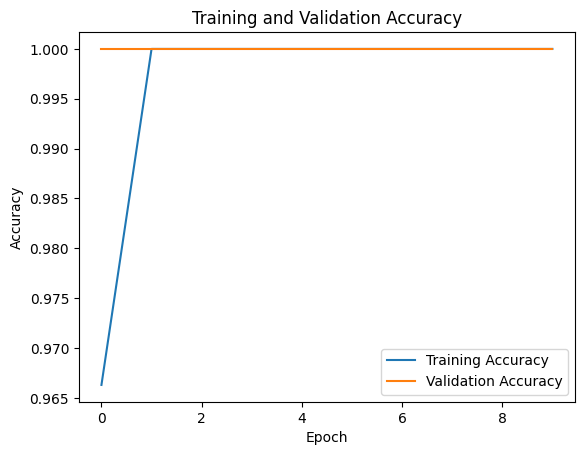

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

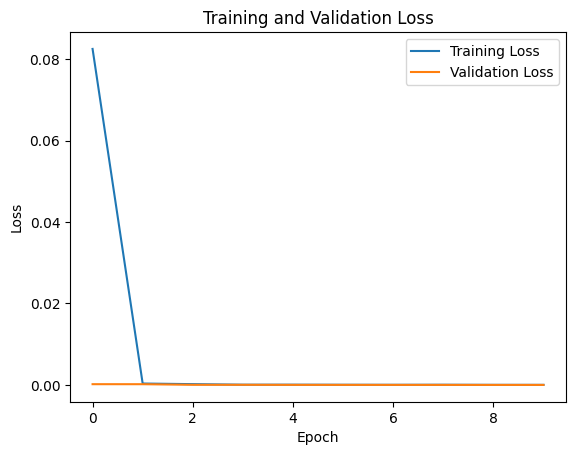

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model.predict(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step


array([[6.58576573e-06],
       [1.43292491e-05],
       [1.75044306e-06],
       [1.25720089e-05],
       [4.68630878e-06],
       [3.14187469e-06],
       [1.02684373e-06],
       [4.77294316e-06],
       [1.14667239e-06],
       [1.67977723e-05],
       [7.58130273e-06],
       [2.72642097e-07],
       [6.67242603e-06],
       [1.70073815e-06],
       [2.26658449e-06],
       [2.09085579e-06],
       [7.51523612e-06],
       [1.07117685e-05],
       [4.37010328e-07],
       [6.44883494e-06],
       [3.68984661e-06],
       [2.32823913e-06],
       [6.08897562e-06],
       [1.31725528e-06],
       [9.20296407e-06],
       [1.07138089e-06],
       [9.76230467e-07],
       [1.18055152e-06],
       [8.86577936e-07],
       [2.74193235e-06],
       [1.42232682e-06],
       [7.14331122e-07],
       [1.63754112e-06],
       [7.78923550e-06],
       [1.43137595e-06],
       [5.28732053e-05],
       [2.33464948e-06],
       [1.06969844e-06],
       [7.12953715e-06],
       [4.37143854e-06],
